In [1]:
!pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 6.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 9.9 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=cbba160ff3b4baf676de82a7854ca776a6b5df9ca697dd605610120a2e8b6b39
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma


In [2]:
import pandas as pd

train = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/train.csv')
test = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/test.csv')
sample_submission = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/sample_submission.csv')

In [3]:
# Fill NaN values with 0 for numeric columns in the train dataset
train = train.fillna({col: 0 for col in train.select_dtypes(include=['number']).columns})

In [4]:
# Fill NaN values with 'Unknown' for text (non-numeric) columns in the train dataset
train = train.fillna({col: 'Unknown' for col in train.select_dtypes(include=['object']).columns})

In [5]:
# Define a function to cap outliers based on the 1st and 99th percentiles
def cap_outliers(df, columns):
    for col in columns:
        lower_bound = df[col].quantile(0.01)
        upper_bound = df[col].quantile(0.99)
        df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
    return df

# Identify numeric columns
numeric_columns = train.select_dtypes(include=['number']).columns

# Cap outliers in numeric columns
train = cap_outliers(train, numeric_columns)

In [6]:
# Calculate correlation of numeric columns with the transplant survival rate (efs)
correlation_with_survival = train.corr(numeric_only=True)['efs'].sort_values(ascending=False)
correlation_with_survival

efs                    1.000000
age_at_hct             0.227865
comorbidity_score      0.143380
donor_age              0.100461
hla_match_drb1_high    0.050371
hla_match_drb1_low     0.045879
hla_low_res_6          0.030798
hla_match_b_low        0.027623
hla_nmdp_6             0.024807
hla_low_res_8          0.022510
hla_high_res_6         0.015232
hla_high_res_8         0.014051
hla_match_a_low        0.013342
hla_match_c_high       0.004956
hla_low_res_10         0.001626
hla_match_b_high       0.000060
hla_match_c_low       -0.000825
hla_match_a_high      -0.001090
hla_high_res_10       -0.001676
ID                    -0.003551
hla_match_dqb1_high   -0.014016
hla_match_dqb1_low    -0.018411
karnofsky_score       -0.020656
year_hct              -0.106422
efs_time              -0.754155
Name: efs, dtype: float64

In [7]:
# Select the features based on the provided correlation positive values
selected_features = [
    'age_at_hct',
    'comorbidity_score',
    'donor_age',
    'hla_match_drb1_high',
    'hla_match_drb1_low',
    'hla_low_res_6',
    'hla_match_b_low',
    'hla_nmdp_6',
    'hla_low_res_8',
    'hla_high_res_6',
    'hla_high_res_8',
    'hla_match_a_low',
    'hla_match_c_high',
    'hla_low_res_10',
    'hla_match_b_high'
]

# Create a new DataFrame with the selected features
train_selected_features = train[selected_features]
train_selected_features

,age_at_hct,comorbidity_score,donor_age,hla_match_drb1_high,hla_match_drb1_low,hla_low_res_6,hla_match_b_low,hla_nmdp_6,hla_low_res_8,hla_high_res_6,hla_high_res_8,hla_match_a_low,hla_match_c_high,hla_low_res_10,hla_match_b_high
0,9.942,0.0,0.000,2.0,2.0,6.0,2.0,6.0,8.0,6.0,0.0,2.0,0.0,10.0,2.0
1,43.705,3.0,72.290,2.0,2.0,6.0,2.0,6.0,8.0,6.0,8.0,2.0,2.0,10.0,2.0
2,33.997,0.0,0.000,2.0,2.0,6.0,2.0,6.0,8.0,6.0,8.0,2.0,2.0,10.0,2.0
3,43.245,0.0,29.230,2.0,2.0,6.0,2.0,6.0,8.0,6.0,8.0,2.0,2.0,10.0,2.0
4,29.740,1.0,56.810,2.0,2.0,6.0,2.0,5.0,8.0,6.0,8.0,2.0,2.0,10.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28795,51.136,0.0,24.212,2.0,2.0,6.0,2.0,6.0,8.0,6.0,8.0,2.0,2.0,10.0,2.0
28796,18.075,3.0,30.770,1.0,2.0,5.0,1.0,4.0,6.0,3.0,4.0,2.0,1.0,8.0,1.0
28797,51.005,5.0,22.627,2.0,2.0,6.0,2.0,6.0,8.0,6.0,8.0,2.0,2.0,10.0,2.0
28798,0.044,1.0,58.074,1.0,1.0,3.0,1.0,3.0,4.0,3.0,4.0,1.0,1.0,5.0,1.0


In [8]:
# Setup 'efs' as the target variable
target = train['efs']

In [9]:
# Perform one-hot encoding for the features and target
encoded_features = pd.get_dummies(train_selected_features, drop_first=True)
encoded_target = pd.get_dummies(target, drop_first=True)

In [10]:
from sklearn.model_selection import train_test_split

# Perform train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    encoded_features, encoded_target, test_size=0.25, stratify=encoded_target, random_state=42
)

In [12]:
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from lifelines.utils import concordance_index
import numpy as np

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Prepare data
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()
y_train_np = y_train.to_numpy().flatten()

c_index_scores = []

# Neural network parameters
input_dim = X_train_np.shape[1]

# KFold cross-validation
for train_index, val_index in kf.split(X_train_np):
    X_train_fold, X_val_fold = X_train_np[train_index], X_train_np[val_index]
    y_train_fold, y_val_fold = y_train_np[train_index], y_train_np[val_index]

    # Build the neural network model
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy')

    # Early stopping
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model
    model.fit(X_train_fold, y_train_fold, validation_data=(X_val_fold, y_val_fold),
              epochs=100, batch_size=64, callbacks=[early_stop], verbose=0)

    # Predict on validation set
    val_predictions = model.predict(X_val_fold).flatten()

    # Calculate Concordance Index
    c_index = concordance_index(y_val_fold, val_predictions)
    c_index_scores.append(c_index)

# Average C-index across folds
average_c_index = np.mean(c_index_scores)

# Predict on test set
test_predictions = model.predict(X_test_np).flatten()

average_c_index, test_predictions

135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step


(0.6463729347145695,
 array([0.392105  , 0.6548803 , 0.52386874, ..., 0.7279849 , 0.8092119 ,
        0.672126  ], dtype=float32))

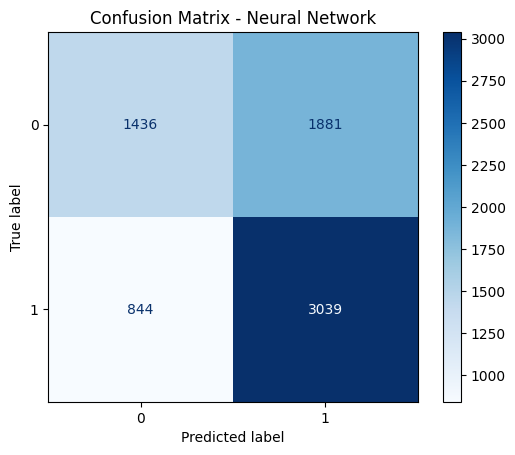

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_test_np = y_test.to_numpy().flatten()

# Convert test predictions to binary (0 or 1) based on a threshold (e.g., 0.5)
binary_test_predictions = (test_predictions >= 0.5).astype(int)

# Calculate confusion matrix
cm = confusion_matrix(y_test_np, binary_test_predictions)

# Visualize confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Neural Network")
plt.show()

The model results :

-   3039 patients were classified as survived (`efs` = 1)

-   1436 patients were classified as not survived (`efs` = 0)

In [15]:
import pickle

# Save the trained neural network model to a pickle file
with open('hct-neural_network_model.pkl', 'wb') as file:
    pickle.dump(model, file)

In [17]:
submission = sample_submission.copy()

In [20]:
submission['prediction'] = test_predictions[:len(submission)]

In [21]:
submission.head()

,ID,prediction
0,28800,0.392105
1,28801,0.654880
2,28802,0.523869


In [22]:
output_csv_path = 'submission.csv'
submission.to_csv(output_csv_path, index=False)